# Definir componentes

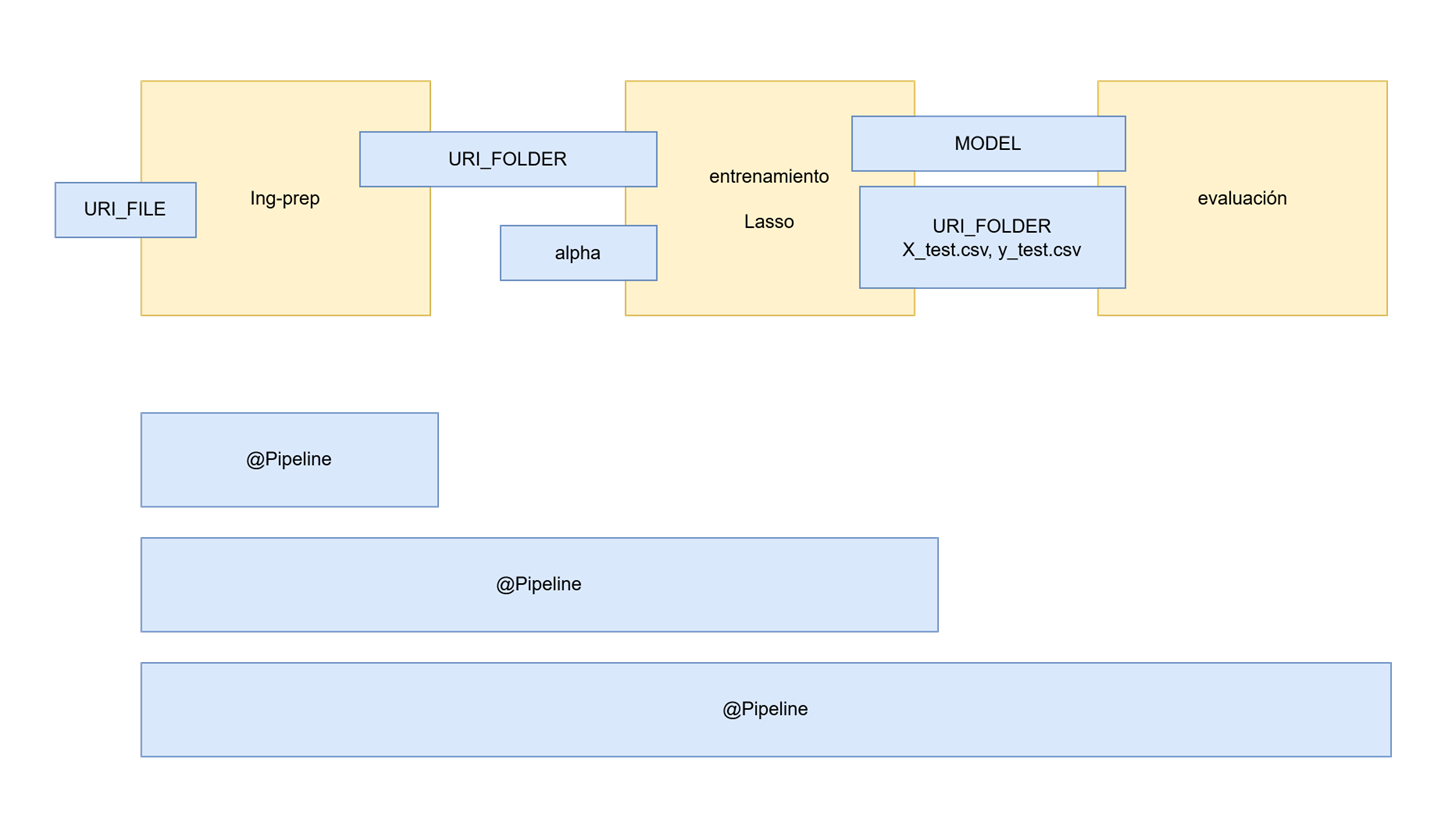

In [ ]:
pip show azure-ai-ml

## Conectar a workspace

In [ ]:
# conectar
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential

ml_client = MLClient.from_config(credential=DefaultAzureCredential())

print(f"Conectado al Workspace: {ml_client.workspace_name}")


## Crear los scripts

In [ ]:
import os

# create a folder for the script files
script_folder = '/home/azureuser/cloudfiles/code/Users/formacion/azure-machine-learning/2.Ciclo_Vida_Creación_Entrenamiento_Modelos/ejercicios/4.ejecutar_pipeline'
os.makedirs(script_folder, exist_ok=True)

os.makedirs(f'{script_folder}/ing-prep-data', exist_ok=True)

print(script_folder, 'folders created')

In [42]:
%%writefile $script_folder/ing-prep-data/ing-prep-data.py

# import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import argparse
from pathlib import Path

import mlflow


def main(args):
    df = read_data(args.input_data)
    df2 = preprocess_data(df)
    
    output_df = df2.to_csv((Path(args.output_data) / "housing_prep.csv"), index = False)



def read_data(uri):
    # 1. Cargar los datos
    data = pd.read_csv(uri)
    # 2. Inspeccionar las columnas
    print(data.columns)

    return data

def preprocess_data(data):
    # 3. Descartar columnas no significativas
    # Las columnas 'date', 'street', 'city', 'statezip', 'country' no son relevantes para la predicción
    columns_to_drop = ['date', 'street', 'city', 'statezip', 'country']
    data = data.drop(columns=columns_to_drop)

    return data


def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument("--input_data", dest='input_data', type=str)
    parser.add_argument("--output_data", dest='output_data',type=str)
    args = parser.parse_args()

    return args


# run script
if __name__ == "__main__":
    args = parse_args()
    main(args)

Overwriting /home/azureuser/cloudfiles/code/Users/formacion/azure-machine-learning/2.Ciclo_Vida_Creación_Entrenamiento_Modelos/ejercicios/4.ejecutar_pipeline/ing-prep-data/ing-prep-data.py


In [43]:
%%writefile /home/azureuser/cloudfiles/code/Users/formacion/azure-machine-learning/2.Ciclo_Vida_Creación_Entrenamiento_Modelos/ejercicios/4.ejecutar_pipeline/ing-prep-data_ric.yml
$schema: https://azuremlschemas.azureedge.net/latest/commandComponent.schema.json
name: ing_prep_data_ric
display_name: Ingerir y preprocesar datos housing Ric
version: 1
type: command
inputs:
  input_data: 
    type: uri_file
outputs:
  output_data:
    type: uri_folder
code: /home/azureuser/cloudfiles/code/Users/formacion/azure-machine-learning/2.Ciclo_Vida_Creación_Entrenamiento_Modelos/ejercicios/4.ejecutar_pipeline/ing-prep-data
environment: azureml:AzureML-sklearn-0.24-ubuntu18.04-py37-cpu@latest
command: >-
  python ing-prep-data.py 
  --input_data ${{inputs.input_data}}
  --output_data ${{outputs.output_data}}

Overwriting /home/azureuser/cloudfiles/code/Users/formacion/azure-machine-learning/2.Ciclo_Vida_Creación_Entrenamiento_Modelos/ejercicios/4.ejecutar_pipeline/ing-prep-data_ric.yml


In [44]:
# Cargar compoente
from azure.ai.ml import load_component

ing_prep_data_ric_comp = load_component(source='/home/azureuser/cloudfiles/code/Users/formacion/azure-machine-learning/2.Ciclo_Vida_Creación_Entrenamiento_Modelos/ejercicios/4.ejecutar_pipeline/ing-prep-data_ric.yml')
ing_prep_data_ric_comp

CommandComponent({'latest_version': None, 'intellectual_property': None, 'auto_increment_version': False, 'source': 'YAML.COMPONENT', 'is_anonymous': False, 'auto_delete_setting': None, 'name': 'ing_prep_data_ric', 'description': None, 'tags': {}, 'properties': {}, 'print_as_yaml': False, 'id': None, 'Resource__source_path': '/home/azureuser/cloudfiles/code/Users/formacion/azure-machine-learning/2.Ciclo_Vida_Creación_Entrenamiento_Modelos/ejercicios/4.ejecutar_pipeline/ing-prep-data_ric.yml', 'base_path': PosixPath('/home/azureuser/cloudfiles/code/Users/formacion/azure-machine-learning/2.Ciclo_Vida_Creación_Entrenamiento_Modelos/ejercicios/4.ejecutar_pipeline'), 'creation_context': None, 'serialize': <msrest.serialization.Serializer object at 0x74ed087852a0>, 'command': 'python ing-prep-data.py  --input_data ${{inputs.input_data}} --output_data ${{outputs.output_data}}', 'code': '/home/azureuser/cloudfiles/code/Users/formacion/azure-machine-learning/2.Ciclo_Vida_Creación_Entrenamiento_

In [ ]:
# registrar componente
# prep_data_comp_reg=ml_client.components.create_or_update(ing_prep_data_ric_comp)

## Build del pipeline

In [ ]:
from azure.ai.ml import Input, Output
from azure.ai.ml.constants import AssetTypes, InputOutputModes

from azure.ai.ml.dsl import pipeline


@pipeline(display_name='housing_ric', experiment_name='housing_ric')
def housing_pipeline(pipeline_job_input):
    ing_prep_data = ing_prep_data_ric_comp(input_data=pipeline_job_input)

    return {
        "pipeline_job_prepared_data": ing_prep_data.outputs.output_data,
    }


pipeline_job = housing_pipeline(
    Input(type=AssetTypes.URI_FILE, path="azureml:housing_prices:2")
    )

In [47]:
# Cambiar el modo de salida
pipeline_job.outputs.pipeline_job_prepared_data.mode = "upload"

# Establecer el proceso
pipeline_job.settings.default_compute = "ricardoenm2"

# Establecer un almacén de datos
pipeline_job.settings.default_datastore = "training_data_ric_2"

In [48]:
# submit job to workspace
pipeline_job = ml_client.jobs.create_or_update(
    pipeline_job, experiment_name="housing_ric"
)
pipeline_job

Uploading ing-prep-data (0.0 MBs): 100%|██████████| 1605/1605 [00:00<00:00, 52820.43it/s]


pathOnCompute is not a known attribute of class <class 'azure.ai.ml._restclient.v2023_04_01_preview.models._models_py3.UriFolderJobOutput'> and will be ignored


Experiment,Name,Type,Status,Details Page
housing_ric,calm_kale_yvdyll4d7w,pipeline,NotStarted,Link to Azure Machine Learning studio
